In [1]:
import pandas as pd
import os
import networkx as nx
import itertools
from netwulf import visualize
import netwulf as nw
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

### Read the datasets into dataframes

In [2]:
author_df = pd.read_csv("C:\\Users\\mansj\\IQL\\data\\databank_deposit_version_2\\exrx_author_final.csv")
article_list = pd.read_csv(r"C:\Users\mansj\IQL\Article_list.csv")

In [3]:
author_df.head()

,ID,Title,author_given_name,author_surname,author_id
0,1,Physical activity in depressed elderly. a syst...,Gioia,Mura,7005321937
1,1,Physical activity in depressed elderly. a syst...,Mauro Giovanni,Carta,7006714673
2,2,Exercise for depression,Gary. M.,Cooney,26028761700
3,2,Exercise for depression,Kerry,Dwan,25027473800
4,2,Exercise for depression,Carolyn A.,Greig,7003441733


In [4]:
article_list.head()

,Our ID,Our Item Type,Item Type,Publication Year,Author,Title,Publication Title,ISSN,DOI,URL,...,Pages,Num Pages,Issue,Volume,Publisher,Place,Language,Type,Our Sorting Date,Our Note
0,1,ReviewArticle,journalArticle,2013,"Mura, Gioia;Carta, Mauro Giovanni",Physical activity in depressed elderly. a syst...,Clinical Practice & Epidemiology in Mental Health,1745-0179,10.2174/1745017901309010125,https://clinical-practice-and-epidemiology-in-...,...,125-135,NaN,1,9,NaN,NaN,en,NaN,7/12/2013,NaN
1,2,ReviewArticle,journalArticle,2013,"Cooney, Gary M;Dwan, Kerry;Greig, Carolyn A;La...",Exercise for depression,Cochrane Database of Systematic Reviews,14651858,10.1002/14651858.CD004366.pub6,http://doi.wiley.com/10.1002/14651858.CD004366...,...,CD004366,NaN,9,2013,NaN,NaN,en,NaN,9/12/2013,NaN
2,3,ReviewArticle,journalArticle,2013,"Mammen, George;Faulkner, Guy",Physical activity and the prevention of depres...,American Journal of Preventive Medicine,7493797,10.1016/j.amepre.2013.08.001,https://linkinghub.elsevier.com/retrieve/pii/S...,...,649-657,NaN,5,45,NaN,NaN,en,NaN,11/1/2013,NaN
3,4,ReviewArticle,journalArticle,2013,"Cramer, Holger;Lauche, Romy;Langhorst, Jost;Do...",Yoga for depression: a systematic review and m...,Depression and Anxiety,10914269,10.1002/da.22166,http://doi.wiley.com/10.1002/da.22166,...,1068-1083,NaN,11,30,NaN,NaN,en,NaN,11/1/2013,NaN
4,5,ReviewArticle,journalArticle,2014,"Josefsson, T.;Lindwall, M.;Archer, T.",Physical exercise intervention in depressive d...,Scandinavian Journal of Medicine & Science in ...,9057188,10.1111/sms.12050,http://doi.wiley.com/10.1111/sms.12050,...,259-272,NaN,2,24,NaN,NaN,en,NaN,4/1/2014,NaN


#### New column in the dataframe for author full_name.

In [5]:
author_df["full_name"] = author_df['author_given_name'] + " " + author_df['author_surname'].fillna('')
author_df.head()
com_df = pd.DataFrame(author_df.groupby('ID')['full_name'].apply(list))
com_df.head()

,full_name
ID,
1,"[Gioia Mura, Mauro Giovanni Carta]"
2,"[Gary. M. Cooney, Kerry Dwan, Carolyn A. Greig..."
3,"[George Mammen, Guy Faulkner]"
4,"[Holger Cramer, Romy Lauche, Jost Langhorst, G..."
5,"[T. Josefsson, M. Lindwall, T. Archer]"


#### Replace the names of author with similar id to the selected key (author name) in the dictionary

In [6]:
list_authors  = pd.DataFrame(author_df.groupby('author_id')['full_name'].apply(list))
auth_list = list_authors.full_name.to_list()

auth_dict = dict()

for i in auth_list:
    i = list(set(i))
    if len(i) > 1:
        auth_dict[i[0]] = i[1:]

#### Function replaces the names of author with same id with the selected key in the dictionary
def replace(auth_name, final_dict):
    for k, v in final_dict.items():
        if auth_name in v:
            auth_name = k
            
    return auth_name
    

author_df.full_name = author_df.full_name.apply(lambda x : replace (x, auth_dict))

#### Check if the author full name is similar in each occurence of the author id 

In [7]:
author_df[author_df.author_id == 7103153350]

,ID,Title,author_given_name,author_surname,author_id,full_name
393,88,Exercise and depression: meeting standards to ...,M.,Trivedi,7103153350,M. Trivedi
430,95,The DOSE study: a clinical trial to examine ef...,Madhukar H.,Trivedi,7103153350,M. Trivedi
485,106,Exercise treatment for depression: Efficacy an...,Madhukar H.,Trivedi,7103153350,M. Trivedi
1088,219,Exercise as an augmentation treatment for nonr...,Madhukar H.,Trivedi,7103153350,M. Trivedi
1168,232,Effects of serum brain derived neurotrophic fa...,Madhukar H.,Trivedi,7103153350,M. Trivedi
1559,291,Pro-inflammatory cytokines as predictors of an...,M. H.,Trivedi,7103153350,M. Trivedi
2501,108,The effect of exercise dose on quality of life...,MH,Trivedi,7103153350,M. Trivedi


#### Get the number of publications by each author. Creates a list of author names who have more than two publications

In [8]:
auth_public = []
publications = author_df.groupby("full_name")["Title"].count().to_dict()
for k, v in publications.items():
    if v >= 2:
        auth_public.append(k)
        
auth_public[:5]

['A Vedamurthachar', 'A. Bishop', 'A. De Herdt', 'A. Dunn', 'A. J. Dobson']

#### Combine the author name and article list to calculate the reviewtype percent for each co-author pair

In [9]:
# Merge the two dataframes to get the title and type of each publication

merged_type_df = pd.merge(com_df, article_list, how = "inner", left_on="ID", right_on="Our ID")
merged_type_df = merged_type_df[["Our ID", "full_name","Our Item Type", "Title"]]
merged_type_df.rename(columns={"Our ID":"ID", "Our Item Type":"item_type", "Title" :"title"}, inplace=True)

# Calculate the co-author review article percent
new  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "ReviewArticle":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                
                if subset not in new.keys():
                    new[subset] = (r_count, i_count)
                else:
                    new[subset] = (new[subset][0] + r_count, new[subset][1] + i_count)
                    
#                 new.append({"auth":subset, "type":type_t})

# Converts to a dataframe with columns including count of review article and included types as well as review percent
df = pd.DataFrame(new.items(), columns=['authors','counts'])
df[['reviews', 'included']] = pd.DataFrame(df['counts'].tolist(), index=df.index)
df[['auth_1', "auth_2"]] = pd.DataFrame(df['authors'].tolist(), index = df.index)
df['total'] = df['reviews'] + df['included']
df['review_percent'] = round(df['reviews']/df['total'] ,3)


# Creates a dataframe for the authors who have more than 3 publications
no_publication_list = []
for i, row in df.iterrows():
    if row['auth_1'] in auth_public or row['auth_2'] in auth_public:
        no_publication_list.append(row)
        
df_publication = pd.DataFrame(no_publication_list)
df_publication.head()

,authors,counts,reviews,included,auth_1,auth_2,total,review_percent
29,"(Holger Cramer, Romy Lauche)","(3, 1)",3,1,Holger Cramer,Romy Lauche,4,0.75
30,"(Holger Cramer, Jost Langhorst)","(1, 0)",1,0,Holger Cramer,Jost Langhorst,1,1.00
31,"(Gustav Dobos, Holger Cramer)","(3, 1)",3,1,Gustav Dobos,Holger Cramer,4,0.75
32,"(Jost Langhorst, Romy Lauche)","(1, 0)",1,0,Jost Langhorst,Romy Lauche,1,1.00
33,"(Gustav Dobos, Romy Lauche)","(3, 1)",3,1,Gustav Dobos,Romy Lauche,4,0.75


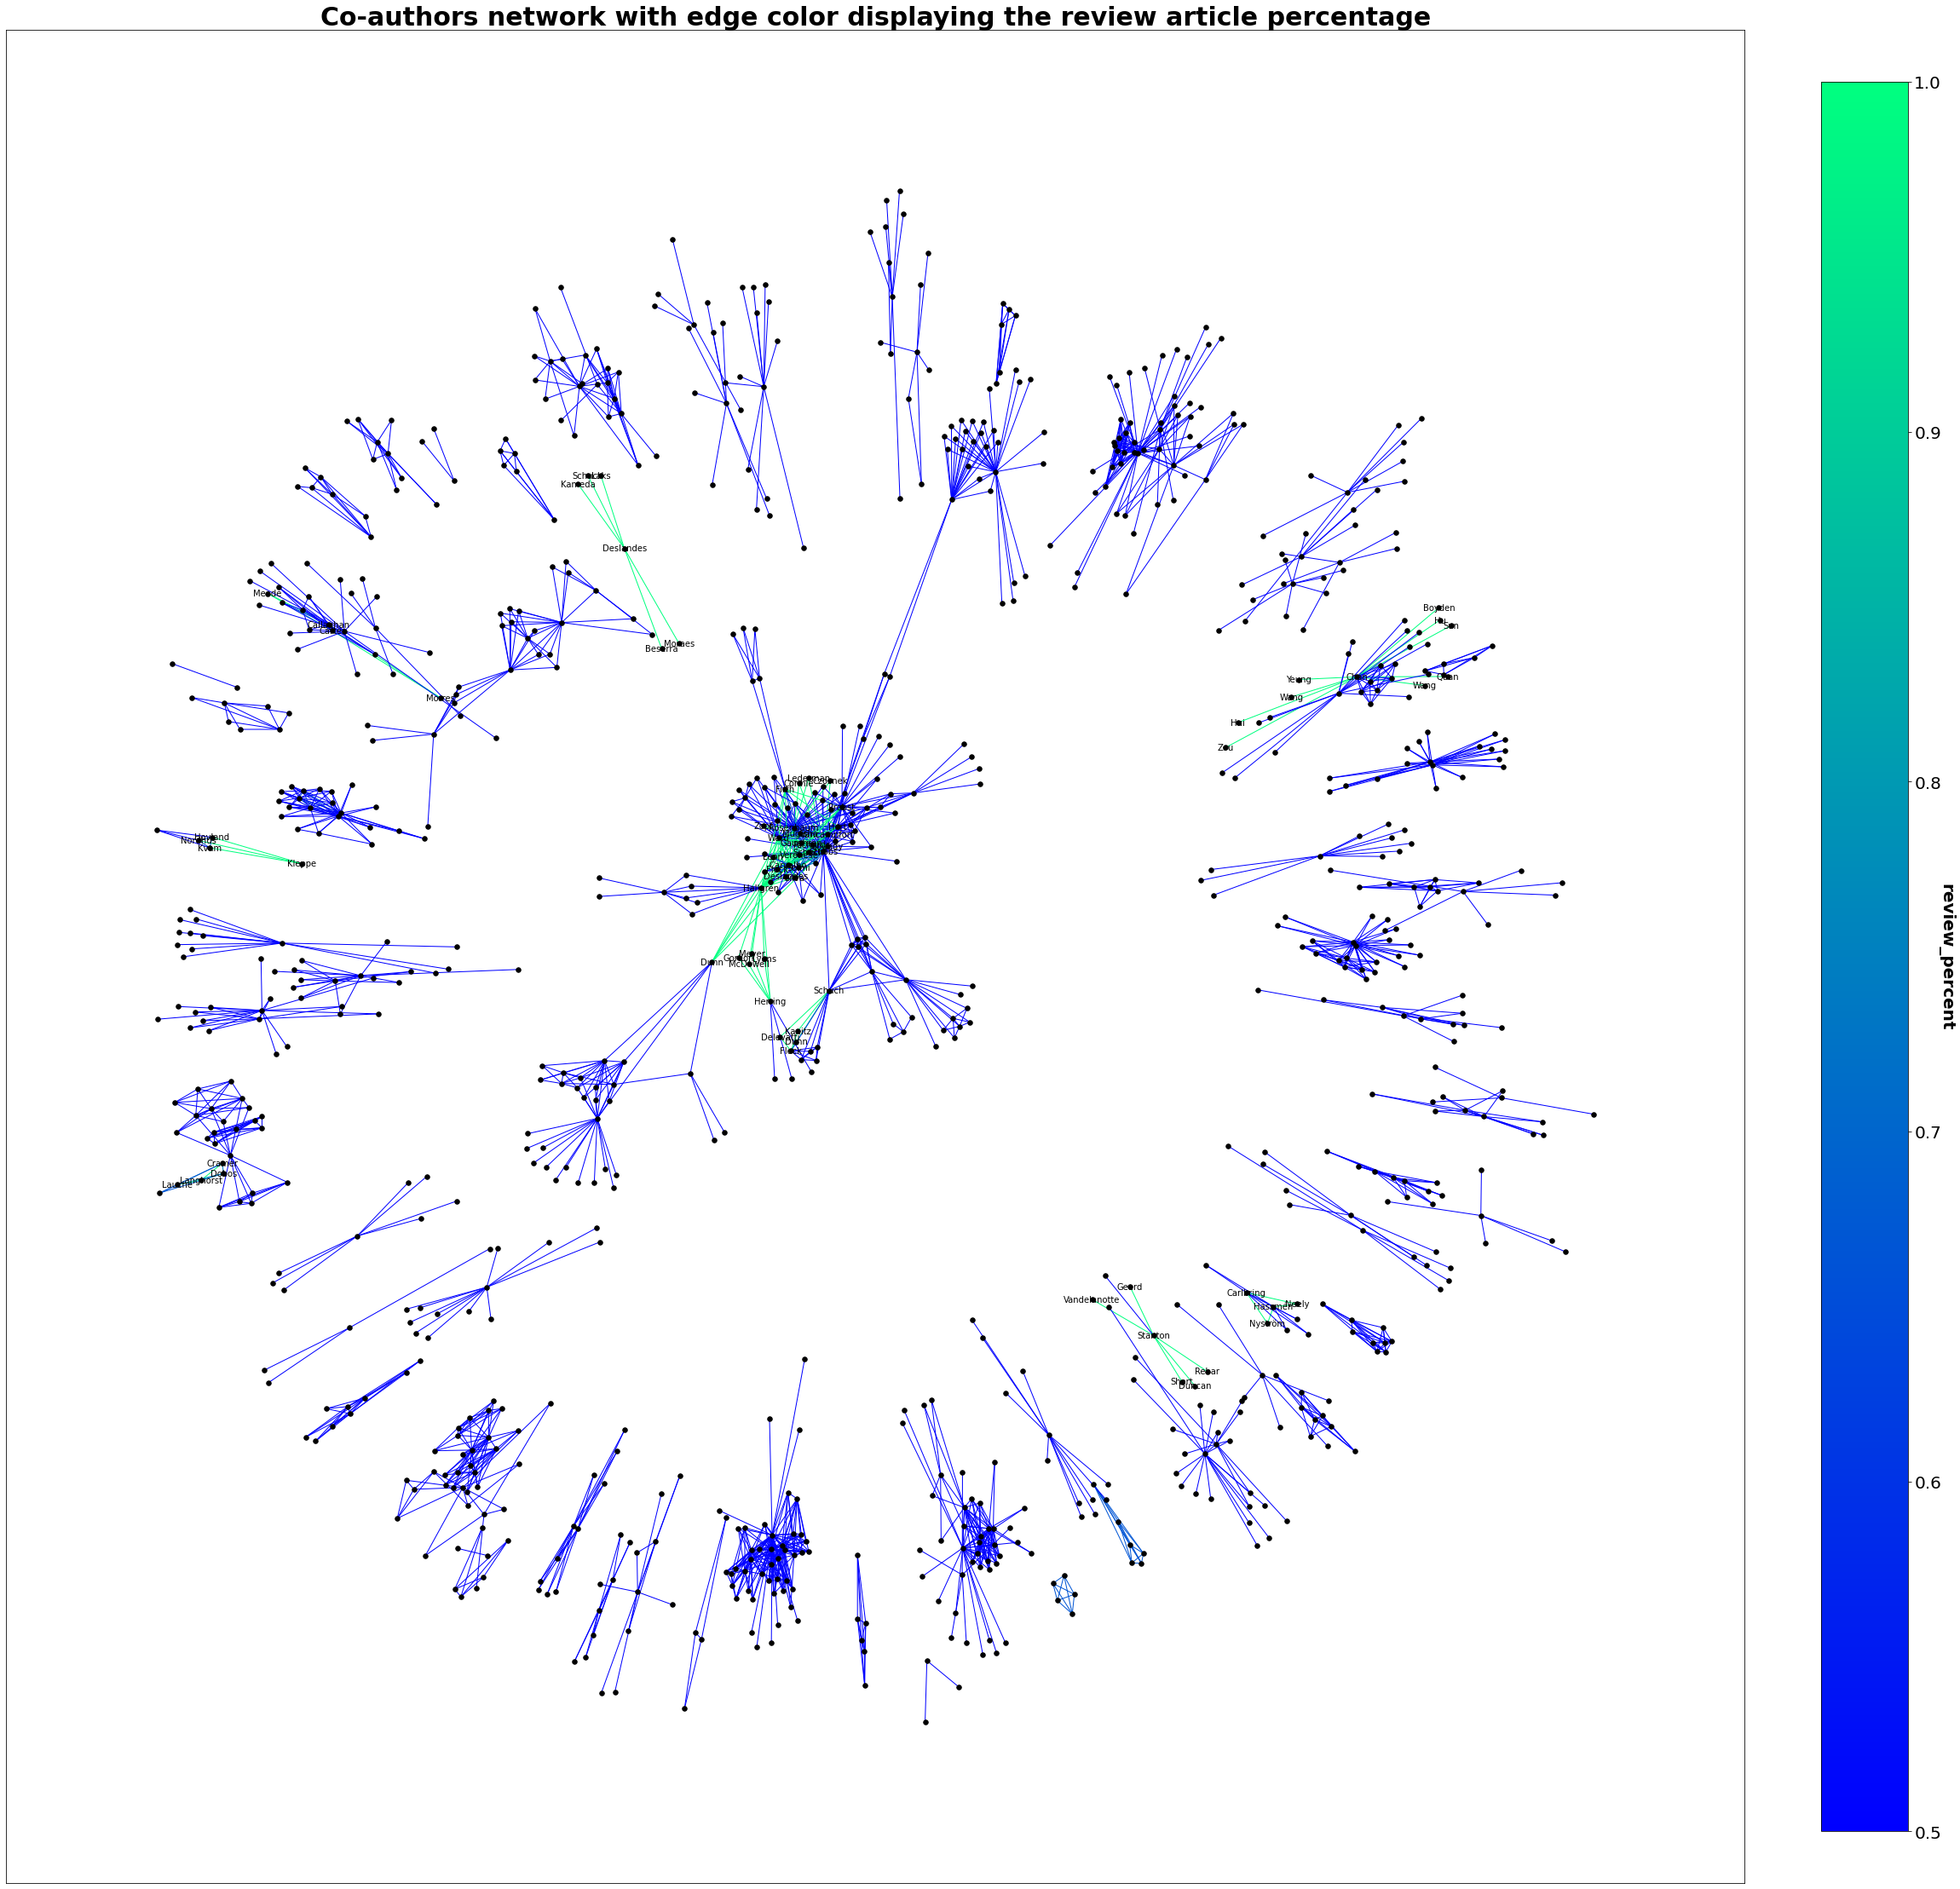

In [15]:
# Create a graph from the number of publication dataframe
G = nx.from_pandas_edgelist(df_publication, "auth_1", "auth_2", edge_attr='review_percent', create_using=nx.Graph())

# Label nodes for authors who have higher published review articles

label_nodes = []

for e in G.edges():
    if G.get_edge_data(e[0],e[1])['review_percent'] >= 0.9:
        label_nodes.append(e[0])
        label_nodes.append(e[1])

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

# splits the last name from the author name to be displayed in the graph
for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]


edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())

# Type of the graph and drawing the node, edges along with the attributes and color for the node with labels
pos = nx.spring_layout(G,scale = 100, k = 0.08)
nodes = nx.draw_networkx_nodes(G, pos=pos,node_size = 30, node_color="black")
edges_1 = nx.draw_networkx_edges(G,pos=pos, edgelist=edges, edge_color=weights,  edge_cmap=plt.cm.winter)
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')


plt.sci(edges_1)

# set the colorbar attributes
cbar = plt.colorbar(fraction=0.046, pad=0.04)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('review_percent', rotation=270,size=20,weight='bold' )

# set the title and figsize for the graph
plt.title("Co-authors network with edge color displaying the review article percentage", size = 30, weight = 'bold')
plt.rcParams["figure.figsize"] = [40, 40]
plt.rcParams["figure.autolayout"] = False


# save the graph
plt.savefig(r"C:\Users\mansj\IQL\CoAuthor Network Visualization\visualizations\edge_color.pdf", dpi = 800)

#### Calculate the review article type percent for each author (i.e. node of the graph) and add as an attribute to the node

In [11]:
new_auth  = {}
r_count = 0
i_count = 0
for i in range(1,len(merged_type_df)):
    name = merged_type_df["full_name"].loc[i]
    type_t = merged_type_df["item_type"].loc[i]
    if type_t == "ReviewArticle":
        r_count = 1
    else:
        i_count = 1
    if len(name) >= 2:
        for subset in itertools.combinations(name,2):
            if len(subset) == 2:
                
                subset = tuple(sorted(subset))
                for i in subset:
                    if i not in new_auth.keys():
                        new_auth[i] = (r_count, i_count)
                    else:
                        new_auth[i] = (new_auth[i][0] + r_count, new_auth[i][1] + i_count)
                    

df = pd.DataFrame(new_auth.items(), columns=['authors','counts'])
df[['reviews', 'study']] = pd.DataFrame(df['counts'].tolist(), index=df.index)
df['total'] = df['reviews'] + df['study']
df['review'] = round(df['reviews']/df['total'],2)

df_attr = df[['authors','review']]
node_attr = df_attr.set_index('authors').to_dict('index')
nx.set_node_attributes(G, node_attr, name = "review_percent")

#### Visualization for node color (i.e. review dominant authors)

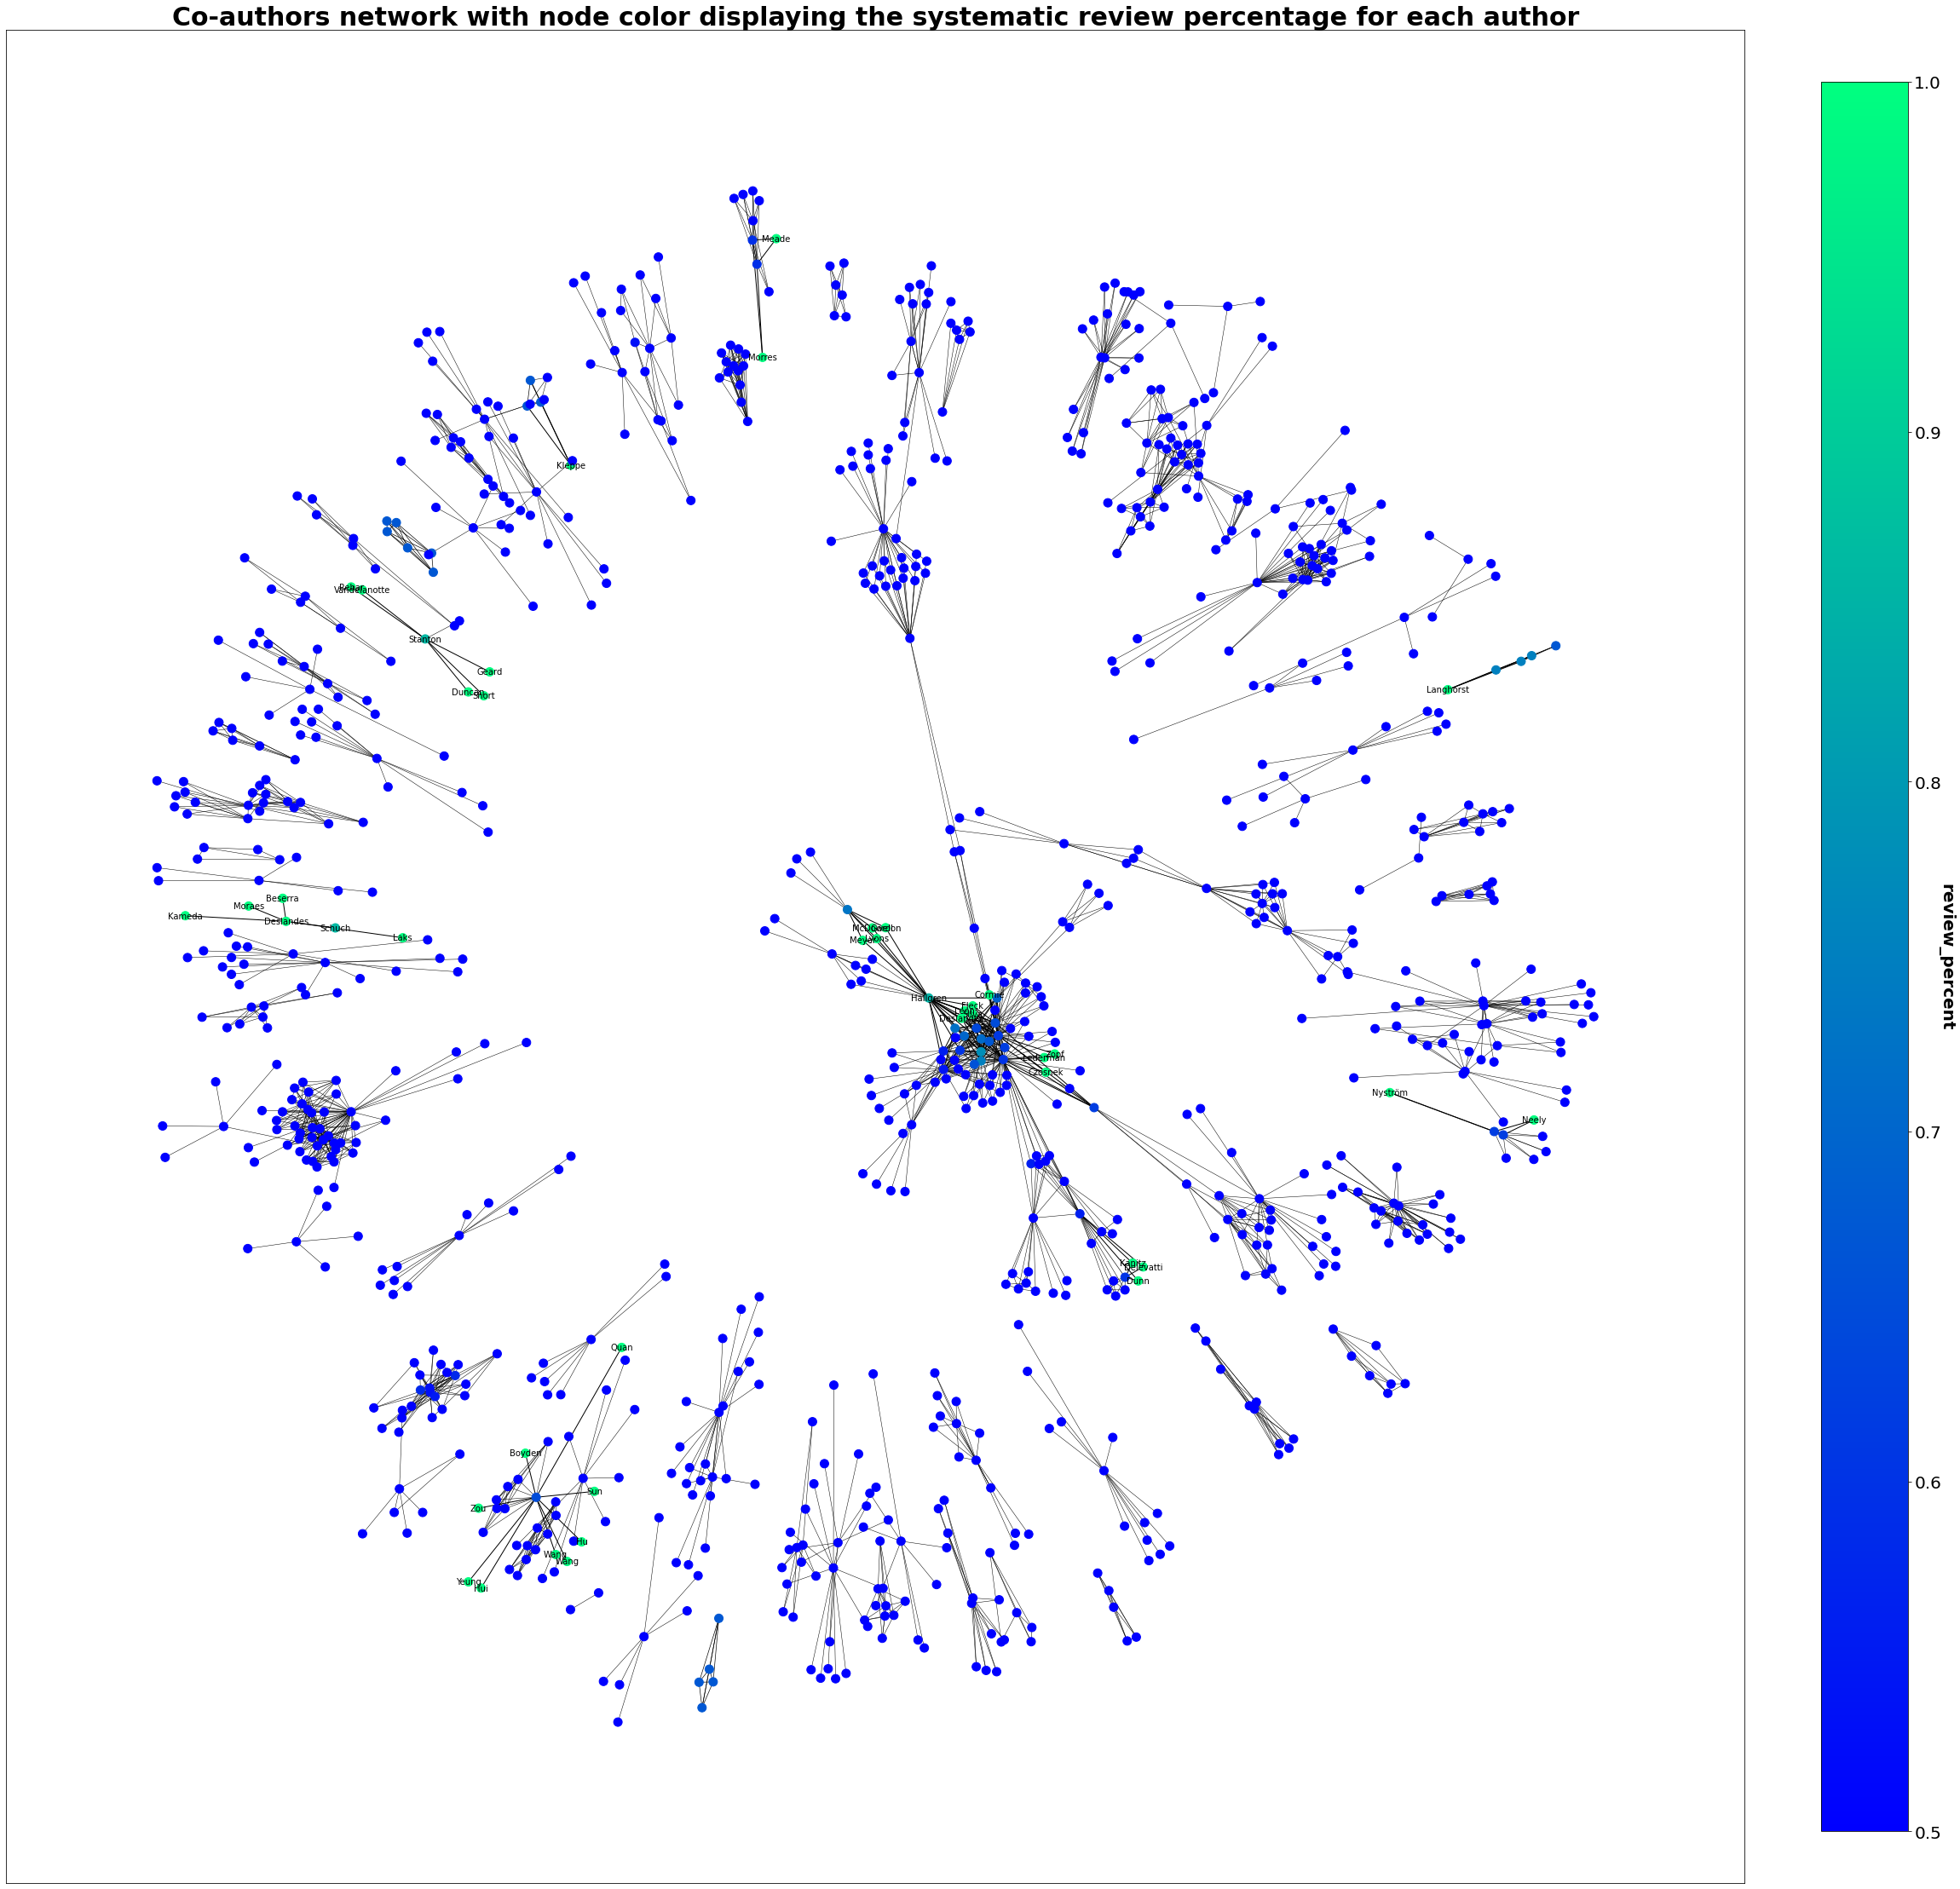

In [12]:
label_nodes = []

# Select authors having a higher review article percent (i.e. review dominant authors)
for n in G.nodes():
    if G.nodes[n]["review_percent"]['review'] >= 0.8:
        label_nodes.append(n)

label_nodes = list(set(label_nodes))
label_nodes

labels = {}

# splits the last name from the author name to be displayed in the graph
for node in G.nodes():
    if node in label_nodes:
        labels[node] = node.split(" ")[-1]

edges,weights = zip(*nx.get_edge_attributes(G,'review_percent').items())
nodes, r_pct = zip(*nx.get_node_attributes(G,'review_percent').items())

node_weight = []
for r in r_pct:
    node_weight.append(r['review'])

pos = nx.spring_layout(G, scale = 100, k = 0.08)
nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_size=100, node_color=node_weight, cmap = plt.cm.winter)
edges_1 = nx.draw_networkx_edges(G,pos=pos, node_size = 10, width=weights, edgelist=edges, edge_color = 'black')
nx.draw_networkx_labels(G, pos,labels,font_size=10,font_color='black')

plt.sci(nodes)

# set the colorbar attributes
cbar = plt.colorbar(fraction=0.046, pad=0.04)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('review_percent', rotation=270,size=20,weight='bold' )

# set the title and figsize for the graph
plt.title("Co-authors network with node color displaying the systematic review percentage for each author", size = 30, weight = 'bold')
plt.rcParams["figure.figsize"] = [40, 40]
plt.rcParams["figure.autolayout"] = False

# save the graph
plt.savefig(r"C:\Users\mansj\IQL\CoAuthor Network Visualization\visualizations\node_color.pdf", dpi = 800)
